In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2020 Rene Delgado(rene854@gmail.com)                                #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

In [2]:
from abc import ABCMeta, abstractmethod

class Enviroment(metaclass=ABCMeta):
  @abstractmethod
  def reward(*args, **kwargs):
    raise NotImplementedError

In [3]:
class Kbandit(Enviroment):
  # @k: # of arms
  # @offset: offset to sum to the mean values
  # @stationary: if False th mean are moving at each time step using a random walk
  def __init__(self, k, offset=0., stationary=True):
    self.k = k
    self.offset = offset
    self.stationary = stationary
    self.init_or_reset()

  def init_or_reset(self):
    self.mean = np.random.randn((self.k)) + self.offset
    self.best_action = np.argmax(self.mean)

  def reset(self):
    self.init_or_reset()

  def reward(self, step_size):
    reward = np.random.normal(self.mean, 1, (step_size, self.k))
    if not self.stationary: # walk
      reward += np.cumsum(np.random.normal(scale=0.1, size=(self.step_size, self.k)), axis=0)
    return reward

In [4]:
class KbanditLearner(object):
  # @env: KBandit enviroment
  # @k: number of k arms
  # @eps: epsilon variable in eps-greedy algorithm
  # @delta: step size to use in grandient base updates and constant value updates
  # @initial: constant where the stimated reward starts at time 0
  # @c: uncertainty variable used in UCB algorithm
  # @gradient: if True, use gradient based bandit algorithm
  # @gradient_base: if True, use average reward as baseline for gradient based bandit algorithm
  def __init__(self, env, eps=0.01, delta=None, initial=None, c=0, gradient=False, gradient_base=True):
    assert issubclass(type(env), Enviroment), ' env msut be an Enviroment subclass'
    self.env = env
    self.k = env.k
    self.eps = eps
    self.delta = delta
    self.estimated_reward = np.zeros(self.k) if not initial else np.ones(self.k)*initial
    self.actions_count = np.zeros(self.k)
    self.c = c
    self.gradient = gradient
    self.gradient_base = gradient_base

  def play(self, step_size):
    # Inicialize
    self.actions_taken = np.zeros(step_size)
    self.obtained_reward = np.zeros(step_size)
    baseline = 0
    one_hot = np.zeros(self.k)
    # Run env
    reward = self.env.reward(step_size)
    # Play
    random_choise = np.random.choice(a=np.arange(self.k), size=(step_size))
    is_greedy = np.random.uniform(size=(step_size)) > self.eps
    
    for i in range(step_size):
      # Taking the action
      if self.gradient:
        exp_est = np.exp(self.estimated_reward)
        self.action_prob = exp_est / np.sum(exp_est)
        action = (np.cumsum(self.action_prob) >= np.random.uniform()).argmax(axis=0)
      elif self.c > 0:
        action = np.argmax(self.estimated_reward + self.c*np.sqrt(np.divide(np.log(i+1), self.actions_count + 1e-5))) if is_greedy[i] else random_choise[i]
      else:
        action = np.argmax(self.estimated_reward) if is_greedy[i] else random_choise[i]  
      self.actions_count[action] += 1
      self.actions_taken[i] = action

      # Update estimation
      if self.gradient:
        one_hot[:] = 0
        one_hot[action] = 1
        if self.gradient_base:
            baseline += (reward[i, action] - baseline) / (i + 1)
        else:
            baseline = 0
        self.estimated_reward += self.delta * (reward[i, action] - baseline) * (one_hot - self.action_prob)
      elif self.delta is None:
        self.estimated_reward[action] += 1/self.actions_count[action]*(reward[i, action] - self.estimated_reward[action])
      else:
        self.estimated_reward[action] += self.delta*(reward[i, action] - self.estimated_reward[action])

      # Saving rewards
      self.obtained_reward[i] = reward[i, action]

  def reset(self):
    self.env.reset()
    self.estimated_reward = np.zeros(self.k)
    self.actions_count = np.zeros(self.k)


In [5]:
class Experiment(object):
  def __init__(self, k, t, runs, configs):
    self.k = k
    self.t = t
    self.runs = runs
    self.configs = [configs] if not isinstance(configs, list) else configs
    self.n_configs = len(self.configs)
    self.hist_R = np.zeros(shape=(self.t, self.runs, self.n_configs))
    self.hist_A = np.zeros(shape=(self.t, self.runs, self.n_configs))
    self.hist_best_action = np.zeros(shape=(self.runs, self.n_configs))
    self.pct_correct = None

  def run(self):
    for i,c in enumerate(tqdm_notebook(self.configs)):
      for n in tqdm_notebook(range(self.runs)):
        ec = c.get('env', {})
        lc = c['learner']
        env = Kbandit(k=self.k, **ec)
        learner = KbanditLearner(env, **lc)
        learner.play(self.t)
        self.hist_R[:,n,i] = learner.obtained_reward
        self.hist_A[:,n, i] = learner.actions_taken
        self.hist_best_action[n, i] = env.best_action


  def pct_correct_over_time(self):
    self.pct_correct = np.ones(shape=(self.t, len(self.configs)))
    for i in range(self.t):
      self.pct_correct[i, :] = np.mean(self.hist_A[i,:,:] == self.hist_best_action, axis=0)


  def plot_pct_correct(self, ax):
    if not self.pct_correct:
      self.pct_correct_over_time()
    ax.plot(self.pct_correct, alpha=0.5)
    ax.legend([str(x) for x in self.configs])
    ax.set_xlabel('Steps', size=20)
    ax.set_ylabel('% optimal action ', size=20)


  def plot_mean_reward(self, ax):
    ax.plot(np.mean(self.hist_R,axis=1), alpha=0.5)
    ax.legend([str(x) for x in self.configs])
    ax.set_xlabel('Steps', size=20)
    ax.set_ylabel('Average reward', size=20)

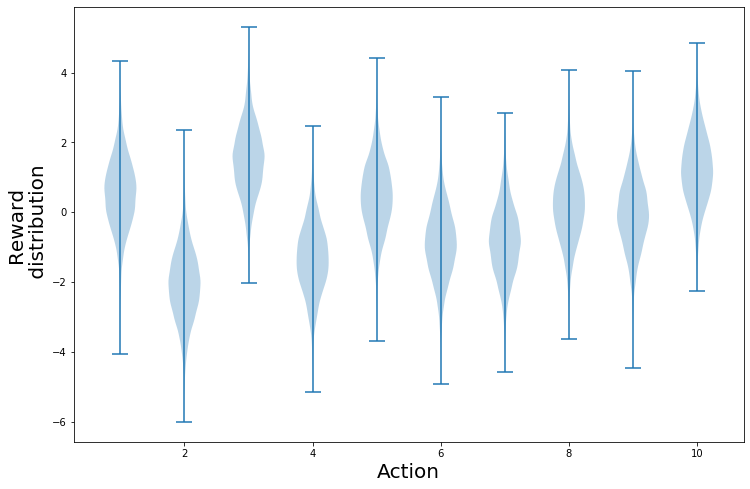

In [6]:
def figure_2_1():
  k = 10
  t = 10000
  env = Kbandit(k=k)
  reward = env.reward(t)
  #plot
  f = plt.figure(figsize=(12,8))
  ax = f.subplots(1,1)
  ax.violinplot(reward)
  ax.set_xlabel('Action', size=20)
  ax.set_ylabel('Reward\n distribution', size=20)

figure_2_1()

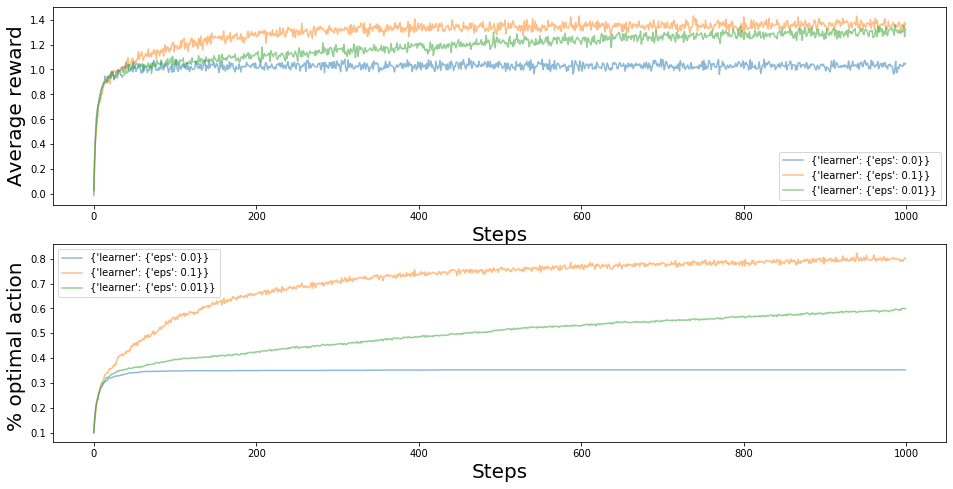

In [7]:
def figure_2_2():
  k = 10
  t = 1000
  runs = 2000
  configs = [{'learner':{'eps': 0.}},  {'learner':{'eps': 0.1}}, {'learner':{'eps': 0.01}}]

  exp = Experiment(k,t,runs,configs)
  exp.run()

  #plot
  f = plt.figure(figsize=(16,8));
  axs = f.subplots(2,1);
  exp.plot_mean_reward(axs[0]);
  exp.plot_pct_correct(axs[1]);

figure_2_2()

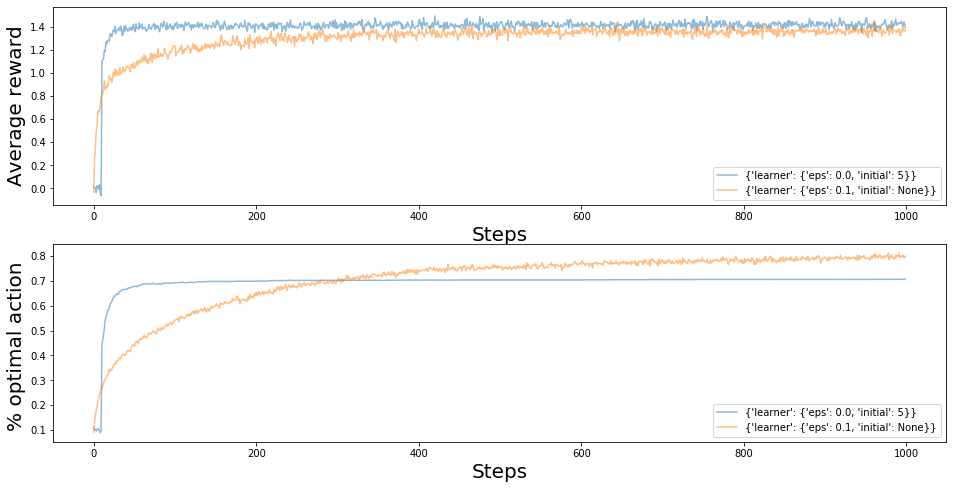

In [8]:
def figure_2_3():
  k = 10
  t = 1000
  runs = 2000
  
  configs = [
    {
      'learner':
      {
        'eps': 0.,
        'initial': 5
      }
    },
    {
      'learner':
      {
        'eps': 0.1,
        'initial': None
      }
    },
  ]

  exp = Experiment(k,t,runs,configs)
  exp.run()

  #plot
  f = plt.figure(figsize=(16,8))
  axs = f.subplots(2,1)
  exp.plot_mean_reward(axs[0])
  exp.plot_pct_correct(axs[1])

figure_2_3()

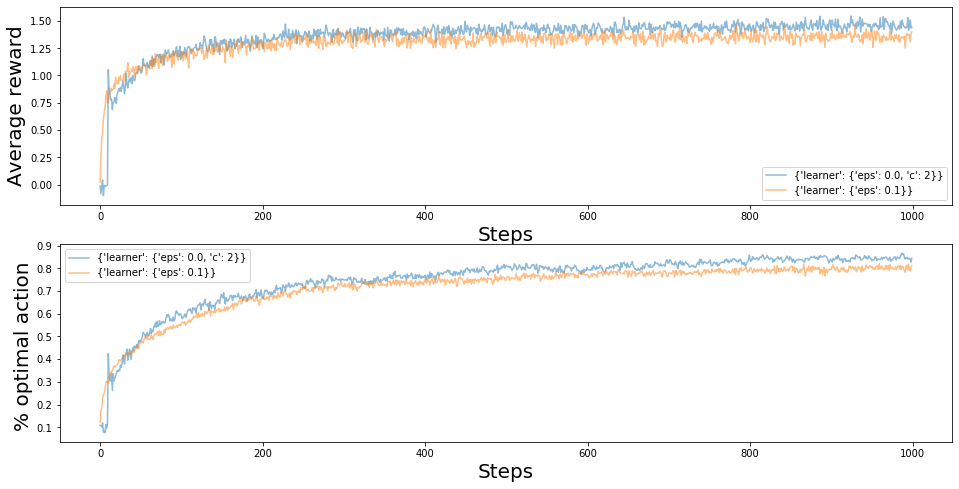

In [9]:
def figure_2_4():
  k = 10
  t = 1000
  runs = 1000
  
  configs = [
    {
      'learner':
       {
        'eps': 0.,
        'c': 2
      }
    },
    {
      'learner':
      {
        'eps': 0.1
      }
    }
  ]

  exp = Experiment(k,t,runs,configs)
  exp.run()

  #plot
  f = plt.figure(figsize=(16,8))
  axs = f.subplots(2,1)
  exp.plot_mean_reward(axs[0])
  exp.plot_pct_correct(axs[1])


figure_2_4()

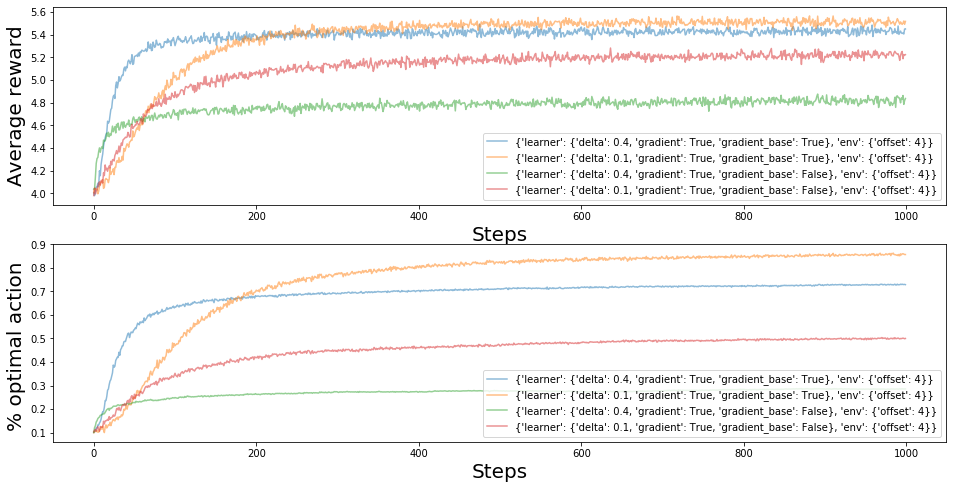

In [10]:
def figure_2_5():
  k = 10
  t = 1000
  runs = 2000
  
  configs = [
    {
      'learner':
        {
          'delta': 0.4,
          'gradient': True,
          'gradient_base': True
        },
      'env': {'offset':4}
    },
    {
      'learner':
        {
          'delta': 0.1,
          'gradient': True,
          'gradient_base': True
        },
      'env': {'offset':4}
    },
    {
      'learner':
        {
          'delta': 0.4,
          'gradient': True,
          'gradient_base': False
        },
      'env': {'offset':4}
    },
    {
      'learner':
        {
          'delta': 0.1,
          'gradient': True,
          'gradient_base': False
        },
      'env': {'offset':4}
    }
  ]

  exp = Experiment(k,t,runs,configs)
  exp.run()

  #plot
  f = plt.figure(figsize=(16,8))
  axs = f.subplots(2,1)
  exp.plot_mean_reward(axs[0])
  exp.plot_pct_correct(axs[1])

figure_2_5()

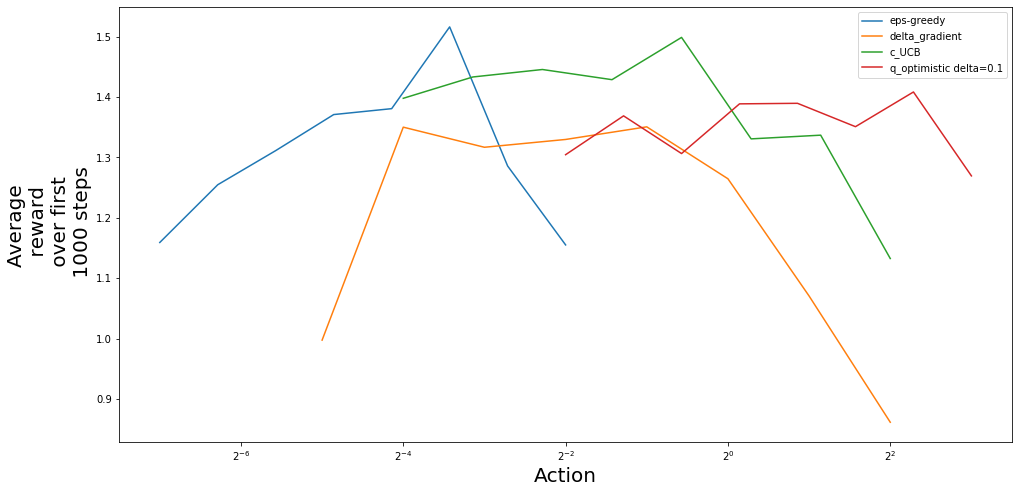

In [12]:
def figure_2_6():
  k = 10
  t = 1000
  runs = 100
  n = 8

  eps_greedy = np.logspace(-7, -2, num=n, base=2)
  delta_gradient = np.logspace(-5, 2,num=n, base=2)
  c_UCB = np.logspace(-4, 2,num=n, base=2)
  q_optimistic = np.logspace(-2, 3,num=n, base=2)
  
  cfg_eps_greedy = [{'learner': {'eps': x}} for x in eps_greedy]
  cfg_delta_gradient = [{'learner': {'delta': x, 'gradient': True}} for x in delta_gradient]
  cfg_c_UCB = [{'learner': {'c': x}} for x in c_UCB]
  cfg_q_optimistic = [{'learner': {'eps':0, 'delta': 0.1, 'initial': x }} for x in q_optimistic]

  xs = [eps_greedy, delta_gradient, c_UCB, q_optimistic]
  ys = np.zeros((len(xs), n))
   
  for i, configs in enumerate([cfg_eps_greedy, cfg_delta_gradient, cfg_c_UCB, cfg_q_optimistic]):
    exp = Experiment(k,t,runs,configs)
    exp.run()
    ys[i, :] = np.mean(exp.hist_R,axis=(0,1))

  f = plt.figure(figsize=(16,8))
  ax = f.subplots(1,1)
  for x,y in zip(xs, ys):
    ax.semilogx(x,y,basex=2)
  ax.legend(['eps-greedy', 'delta_gradient', 'c_UCB', 'q_optimistic delta=0.1'])
  ax.set_xlabel('Action', size=20)
  ax.set_ylabel('Average\n reward\n over first\n 1000 steps', size=20)

figure_2_6()